# AIMasters Computer Vision and Video Processing &mdash; Image deblurring task

<img src="images/blur.png">

In the first task of the course you will have to implement an image deblurring method.  
We will start with the simplest possible network and by the end of the task you will implement SOTA deblurring architecture.

## Preliminaries

In [1]:
from utils import download_from_yadisk, test_model
import os

TARGET_DIR = '.'
FILENAME = "GoPro.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 5.2 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/v7O5TOsstnsscw',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

In [2]:
# !UNZIP_DISABLE_ZIPBOMB_DETECTION=TRUE unzip -qq GoPro.zip

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

from torchvision import transforms
from PIL import Image
import os

print(f"GPU: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU: True


### Prepare Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        blur_path = Path(f"{root_dir}/blur")
        sharp_path = Path(f"{root_dir}/sharp")
        self.blurry_images = [p.name for p in list(blur_path.glob("*.png"))]

    def __len__(self):
        return len(self.blurry_images)

    def __getitem__(self, idx):
        blurry_path = Path(self.root_dir, 'blur', self.blurry_images[idx])
        sharp_path = Path(self.root_dir, 'sharp', self.blurry_images[idx]) 

        blurry_image = np.array(Image.open(blurry_path).convert('RGB'))
        sharp_image = np.array(Image.open(sharp_path).convert('RGB'))

        if self.transform:
            blurry_image = blurry_image.astype(np.float32)/255.0
            sharp_image = sharp_image.astype(np.float32)/255.0
            augmented = self.transform(image=blurry_image, image1=sharp_image)
            blurry_image = augmented['image']
            blurry_image = blurry_image.to(torch.float32)
            sharp_image = augmented['image1']
            sharp_image = sharp_image.to(torch.float32)

        return blurry_image, sharp_image

transform = A.Compose([
    A.RandomCrop(256, 256, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5), 
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

transform_test = A.Compose([
    ToTensorV2(),
], additional_targets={
        'image1': 'image'}, p=1)

train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=16)

test_dataset = GoProDataset(root_dir='GoPro/test', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

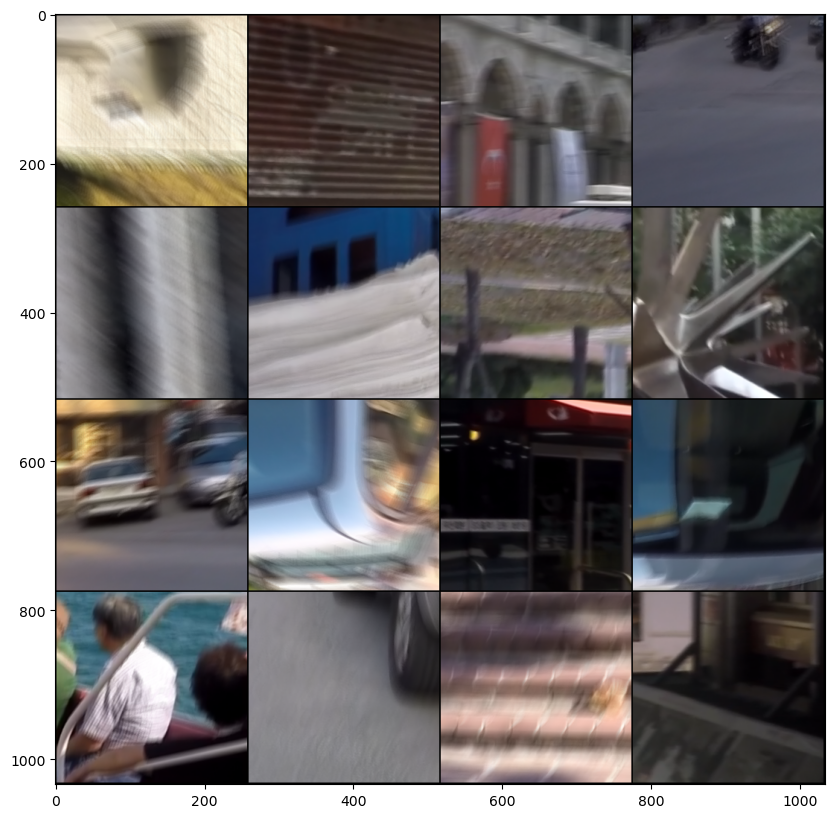

In [8]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

## Baseline

### Basic network (1 point)
We will start off by implementing the simplest possible convolutional neural network.  
A few convolutional layers, without pooling.

Remenicent of early works in [Super-Resolution](https://arxiv.org/abs/1501.00092) and [Denoising](https://arxiv.org/abs/1608.03981)

**Important to note that our network will learn the residual for debluring**  
$I_{deblur}=I_{input} + f_{\theta}(I_{input})$

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBnBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        """Simple convolutional block

        Your task is to fill in the following modules:

            conv + bn + relu
        
        """
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            padding='same'
        )

        self.bn = nn.LazyBatchNorm2d()
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class Baseline(nn.Module):
    def __init__(self, block, n_blocks=5, n_filters=64, inout_kernel_size=1, block_kernel_size=5):
        """Basic convolutional model
        
        Your task is to implement the following architecture:

            input_conv(3, n_filters)
            n_blocks * ConvBnBlock
            output_conv(n_filters, 3)
        
        """

        super().__init__()
        
        self.input_conv = nn.Conv2d(
            in_channels=3, 
            out_channels=n_filters, 
            kernel_size=inout_kernel_size,
            padding='same'
        )
    
        self.blocks = nn.Sequential(
            *(block(n_filters, n_filters, block_kernel_size) for _ in range(n_blocks))
        )
        
        self.output_conv = nn.Conv2d(
            in_channels=n_filters, 
            out_channels=3,
            kernel_size=inout_kernel_size,
            padding='same'
        )

    def forward(self, x):
        inp = x
        x = self.input_conv(x)
        x = self.blocks(x)
        x = self.output_conv(x)

        return x + inp

In [10]:
baseline = Baseline(ConvBnBlock)
test_input = torch.rand(1, 3, 256, 256)
test_output = baseline(test_input)
assert test_input.shape == test_output.shape

/home/denis/miniconda3/envs/cv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### PSNR Loss (0.5 points)

We will directly optimize the PSNR quality metric instead of plain MSE  
$PSNR = 10 * \log_{10}(\frac{MAX_I^2}{MSE})$  
In out case the images are normed to [0, 1], so the $MAX_I=1$

Be careful when averaging, first calculate the MSE for each pair of images, only then apply log and after that average along batch axis. 

In [11]:
class PSNRLoss(nn.Module):
    def __init__(self):
        """Peak signal-to-noise ratio loss function
        
        NOTE: during training we minimize the loss but greater PSNR mean better
        So you may carry the -1 into the log when implementing
        thus elimating the need for division
        """
        super().__init__()
        self.eps = 1e-8  # use eps to prevent 0 in log

    def forward(self, pred, target):
        """
            Implement the following calculation:

                10 * mean(log10(mse(pred, target)))

        """

        return torch.mean(
            10 * torch.log10(
                self.eps + 
                torch.mean((pred - target)**2, axis=(-1, -2))
            )
        )


In [12]:
criterion = PSNRLoss()
a = torch.tensor([[[[0.1632, 0.0024, 0.9913, 0.8892],
          [0.5655, 0.4472, 0.4592, 0.2013],
          [0.7722, 0.9089, 0.1708, 0.3654],
          [0.6147, 0.9567, 0.7018, 0.2376]]]])
b = torch.tensor([[[[0.8498, 0.1168, 0.3987, 0.6781],
          [0.7864, 0.9762, 0.3694, 0.9926],
          [0.9000, 0.0293, 0.0454, 0.0984],
          [0.9478, 0.3730, 0.9617, 0.5052]]]])

assert torch.isclose(criterion(a, b), torch.tensor(-6.8417))

### Training (0.5 points)
Basic training pipeline.

Note the use of gradient clipping, while not required to train the simplest model it will greately help for later parts of the task!

Hint: use [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html), `max_norm=0.05` worked fine

In [13]:
from tqdm.notebook import tqdm

In [14]:
def train_model(
        model, train_dataloader, optimizer, criterion, scheduler, 
        num_epochs=200, checkpoints_path="./checkpoints", use_grad_clip=True,
        max_norm=0.05
    ):
    # Create checkpoints folder
    PATH = checkpoints_path
    os.makedirs(PATH, exist_ok = True)
    
    losses = []

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for inputs, targets in train_dataloader:
            # Your code vvv
            optimizer.zero_grad()        

            inputs = inputs.to(device)
            targets = targets.to(device)

            predict = model(inputs)
            loss = criterion(predict, targets)

            loss.backward()

            if use_grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            
            optimizer.step()

            losses.append(loss.item())
    
        torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict()
                  }, os.path.join(PATH, f"epoch_{epoch+1}.tar"))
    
        # Update the learning rate
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {np.mean(losses)}, LR: {scheduler.get_last_lr()[0]}')

In [15]:
from utils import get_scheduler

torch.manual_seed(11)

model = Baseline(ConvBnBlock)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

# train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=50)

In [12]:
result = test_model(model, device, test_dataloader)
assert result <= 0.00252
print("Congrats!")

100%|██████████| 634/634 [03:51<00:00,  2.74it/s]

Mean MSE: 0.0023349500130147973
Congrats!


/home/denis/miniconda3/envs/cv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


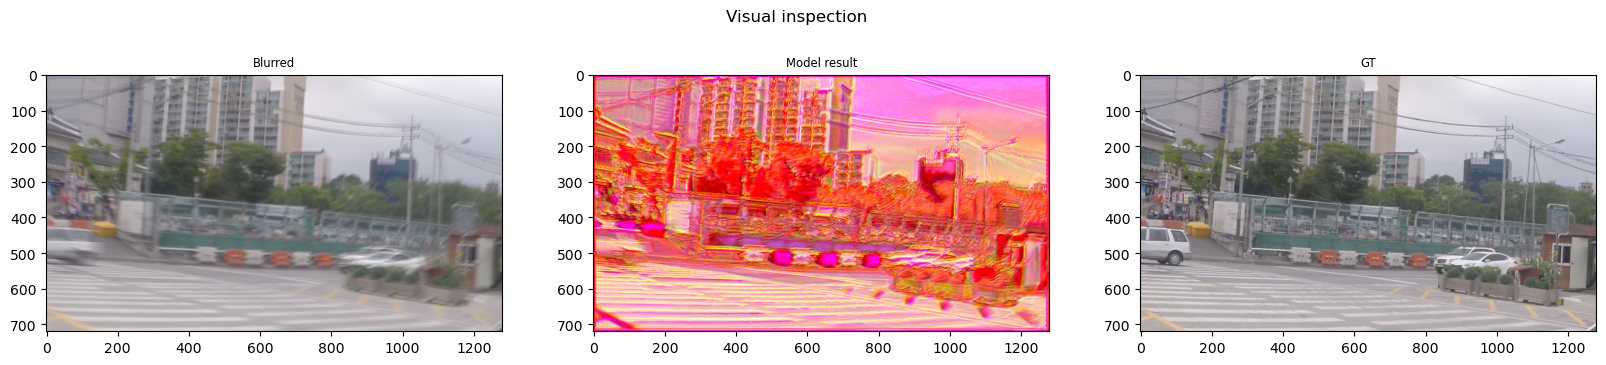

In [16]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## UNet

The next step is to process our image in multiple scales, like the multi-scale methods of old school CV.

The most common model that uses multiple scales is the [UNet](https://arxiv.org/abs/1505.04597), first proposed for medical segmentation and containing many strange design decisions.  
Nonetheless, it has proven to be useful for many CV tasks and is videly used in image and video restoration.

U-Nets are named as such because they have this U-like shape, where the input image is first reduced in dimensionality in the downsizing portion, then increased in dimensionality back to its original size in the upsizing portion.

<img src="images/unet.png">


UNet may be implemented with either concatenation of skip-connections or with the summation.  
The results usually do not differ that much.

### Double convolution (0.5 points)
In UNet each convolution block is created with two convolutions.  
You have to implement a simple stack of two layers of convolution with two ReLU activations

In [13]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels):
        """Basic building block of UNet architecture
        
        Your task is to fill in the following modules:

            conv + bn + relu + conv + bn + relu
            
        """
        super().__init__()
        self.conv_1 = nn.Conv2d(
            in_channels=in_channels,
            kernel_size=3,
            out_channels=in_channels,
            padding='same'
        )

        self.bn_1 = nn.LazyBatchNorm2d()
        self.relu_1 = nn.ReLU()

        self.conv_2 = nn.Conv2d(
            in_channels=in_channels,
            kernel_size=3,
            out_channels=in_channels,
            padding='same'
        )

        self.bn_2 = nn.LazyBatchNorm2d()
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu_2(x)

        return x


In [14]:
block = UNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### UNet Down block (0.5 points)

In [15]:
class UNetDownBlock(nn.Module):
    def __init__(self, chan):
        """Downsampling block in the encoder of UNet

            Your task is to fill in the following modules:
            
                AvgPool + Conv 1x1

            Input spatial dimension is **reduced** by a factor of 2  
            The number of channels is **increased** by a factor of 2
        """
        super().__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=2)
        self.conv = nn.Conv2d(kernel_size=1, in_channels=chan, out_channels=2*chan)

    
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.conv(x)

        return x

In [16]:
block = UNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### UNet Up block (0.5 points)

In [17]:
class UNetUpBlock(nn.Module):
    def __init__(self, chan):
        """Upsampling block in the encoder of UNet

            Your task is to fill in the following modules:
            
                Upsample + Conv2d

            Input spatial dimension is **increased** by a factor of 2  
            The number of channels is **reduced** by a factor of 2
        """
        super(UNetUpBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(
            in_channels=chan, 
            out_channels=chan // 2, 
            kernel_size=3, 
            padding='same'
        )

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)

        return x

In [18]:
block = UNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### Generalized Unet arch (1.5 points)
Over the years the UNet architecture has proven itself useful.  
Many follow up papers retain macro level architecture and change individual blocks, i.e. only changing the downscaling operation, changing number of convs in block, adding attention to bottleneck, etc.  

Therefore we will also implement a generalized architecture.

**Your model must pass the quality assert to get points for this part**

In [19]:
class GeneralizedUNet(nn.Module):
    def __init__(self, block, downBlock, upBlock, img_channel=3, width=16, 
                 middle_blk_num=1, enc_blk_nums=[1,1,1,1], dec_blk_nums=[1,1,1,1]):
        """GeneralizedUNet architecture
        
            This part is implemented for you
            But feel free to change it

        """
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1, bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1, bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                downBlock(chan)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[block(chan) for _ in range(middle_blk_num)]
            )
        
        for num in dec_blk_nums:
            self.ups.append(
                upBlock(chan)
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[block(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        """Performs forward pass of a UNet-like model

        Your task is to implement the following steps:

            1. Intro convolution
            2. Encoder blocks + save skip connections + downsample
            3. Middle blocks (also known as bottleneck)
            4. Decoder blocks + add skip connection
            5. Ending
            6. Inp + ending out (we're still using residual lerning)

        """
        activations = []
        
        x = self.intro(inp)

        for enc, down in zip(self.encoders, self.downs):
            act = enc(x)
            activations.append(act)
            x = down(act)
        
        x = self.middle_blks(x)

        for decoder, up, act in zip(self.decoders, self.ups, activations[::-1]):
            x = up(x)
            x = decoder(x)
            x = x + act # что то с каналами не то

        x = self.ending(x)

        return inp + x


In [20]:
model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
vec = torch.rand(16, 3, 256, 256)
assert model(vec).shape == torch.Size([16, 3, 256, 256])

### Train UNet

In [21]:
torch.manual_seed(11)

model = GeneralizedUNet(UNetBlock, UNetDownBlock, UNetUpBlock)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=30, use_grad_clip=use_grad_clip)

In [64]:
result = test_model(model, device, test_dataloader)
assert result <= 0.00235

100%|██████████| 634/634 [01:17<00:00,  8.19it/s]

Mean MSE: 0.0022950018127814516


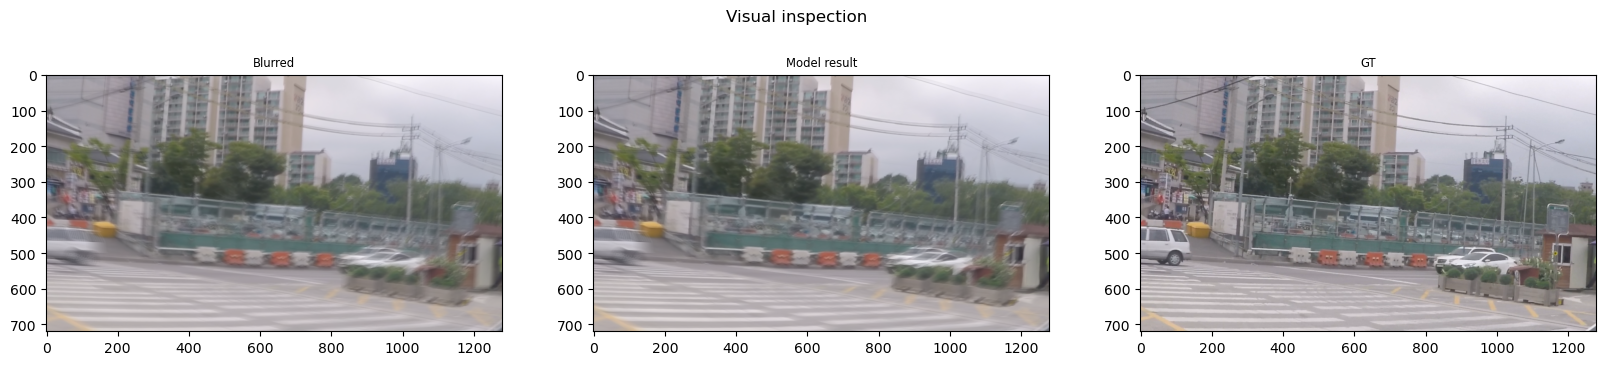

In [65]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

## NAFNet
As discussed in the previous section, many networks build upon UNet and change individual blocks.  
[NAFNet](https://arxiv.org/abs/2204.04676) was for a long time a SOTA deblurring approach, even thought it was presented as a baseline. 

The main differences are:
* No regular nonlinearities (no ReLU/GELU/ELU/etc.)
* Simplified channel attention
* LayerNorm instead of BatchNorm
* and many more training tricks taken from transformer papers

In a way this work is similar to [ConvNeXt](https://arxiv.org/abs/2201.03545), where authors also shook off the dust of ResNet and trained a SOTA classification CNN.


**And now you are tasked with implementing NAFNet :)**

### Simple gate block (0.5 points)

<img src="images/gate.png">

Instead of using regular non-linearities NAFNet proposes the use of "Simple Gates" which perform pointwise multiplication of feature maps.

Simple gate layer splits input feature map in 2 part along the channel axis and multiplies them.

You may find [`torch.chunk`](https://pytorch.org/docs/stable/generated/torch.chunk.html) to be useful

In [22]:
class SimpleGate(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        
            Split the input in 2, along the channel axis
            Return multiplication of these 2 parts
        
        """

        x = x.chunk(2, dim=1)

        return x[0] * x[1] 

In [23]:
block = SimpleGate()
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

### NAFNet up block (0.5 points)

In [24]:
class NAFNetUpBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet upsampling block
        
        Implement and use the following modules:

            conv 1x1 (chan, 2 * chan)
            pixelshuffle(2)
        
        """
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=channels,
            out_channels=2*channels,
            kernel_size=1
        )
        self.px = nn.PixelShuffle(2)


    def forward(self, x):
        x = self.conv(x)
        x = self.px(x)

        return x

In [25]:
block = NAFNetUpBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 512, 512])

### NAFNet down block (0.5 points)

In [26]:
class NAFNetDownBlock(nn.Module):
    def __init__(self, channels):
        """NAFNet downsampling block
        
        Implement and use the following modules:
        
            conv with stride 2, **mind the padding**

        """
        super().__init__()

        self.conv = nn.Conv2d(
            in_channels=channels,
            out_channels=2*channels,
            stride=2,
            kernel_size=1,
        )

    def forward(self, x):
        return self.conv(x)

In [27]:
block = NAFNetDownBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 128, 128, 128])

### Simplified channel attention (0.5 points)

Regular channel attention produces weights for each channel of input feature map using 2-layer MLP.  
NAFNet authors propose to remove the small MLP on channels by just pooling and linearly projecting the feature map to get channel weights.

<img src="images/sca.png">

In [28]:
class SCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        """Simplified channel attention module
        
        Implement and use the following modules:
        
            adaptiveavgpool to get 1x1 feature map
            conv 1x1 projection layer
        
        """
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        
            Return only the attention weights
        
        """
        x = nn.functional.adaptive_avg_pool2d(x, x.shape[-2:])
        x = self.conv(x)

        return x

In [29]:
block = SCA(64, 32)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 32, 256, 256])

### NAFNet block (3 points)

**The final boss of the task**.

The diagram shows the intra-block structure:

<img src="images/nafnet_block.png" width=620>

Note the use of learnable skip-connection scales `beta` and `gamma`, use [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)

**Your model must pass the quality assert to get points for this part**

In [30]:
from utils import LayerNorm2d  # use this layernorm

class NAFNetBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2):
        super().__init__()

        dw_channel = c * DW_Expand
        ffn_channel = FFN_Expand * c

        self.beta = nn.Parameter(torch.tensor(0.5))
        self.gamma = nn.Parameter(torch.tensor(0.5))

        # self.layer_1 = nn.LayerNorm((256, 256))
        self.conv_1 = nn.Conv2d(
            in_channels=c,
            out_channels=dw_channel,
            kernel_size=1,
        )
        self.conv_2 = nn.Conv2d(
            in_channels=dw_channel,
            out_channels=dw_channel,
            kernel_size=3,
            padding='same'
        )
        self.gate_1 = SimpleGate()
        self.sca = SCA(dw_channel // 2, dw_channel//2)
        self.conv_3 = nn.Conv2d(
            in_channels=dw_channel//2,
            out_channels=c,
            kernel_size=1
        )

        # self.layer_2 = nn.LayerNorm((256, 256))
        self.conv_4 = nn.Conv2d(
            in_channels=c,
            out_channels=ffn_channel,
            kernel_size=3,
            padding='same'
        )
        self.gate_2 = SimpleGate()
        self.conv_5 = nn.Conv2d(
            in_channels=ffn_channel//2,
            out_channels=c,
            kernel_size=3,
            padding='same'
        )
    

    def forward(self, inp):
        
        x = torch.nn.functional.layer_norm(inp, inp.shape[-2:])
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.gate_1(x)
        sca = self.sca(x)
        x = self.conv_3(sca * x)
        x = x * self.beta

        inp_2 = inp + x
        x = torch.nn.functional.layer_norm(inp_2, inp_2.shape[-2:])
        x = self.conv_4(x)
        x = self.gate_2(x)
        x = self.conv_5(x)
        x = x * self.gamma + inp_2

        return x

In [31]:
block = NAFNetBlock(64)
vec = torch.rand(16, 64, 256, 256)
assert block(vec).shape == torch.Size([16, 64, 256, 256])

### Train NAFNet

In [32]:
torch.manual_seed(11)

model = GeneralizedUNet(
    NAFNetBlock, 
    NAFNetDownBlock, 
    NAFNetUpBlock, 
    enc_blk_nums=[1,2,2,28], 
    dec_blk_nums=[2,2,2,1],
    
)
model = model.to(device)

criterion = PSNRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
use_grad_clip = True
scheduler = get_scheduler(optimizer)

# train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=25)

In [40]:
train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

/home/denis/miniconda3/envs/cv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Loss: -26.421081034161055, LR: 0.000975530705321762
Epoch 2, Loss: -26.290934838173904, LR: 0.0009045180463377549
Epoch 3, Loss: -26.26995086035046, LR: 0.0007939132368836219
Epoch 4, Loss: -26.31765253941785, LR: 0.0006545430463377549
Epoch 5, Loss: -26.380523894142662, LR: 0.0005000499999999999
Epoch 6, Loss: -26.46278095812215, LR: 0.00034555695366224505
Epoch 7, Loss: -26.53322063299894, LR: 0.0002061867631163781
Epoch 8, Loss: -26.61420020414317, LR: 9.558195366224507e-05
Epoch 9, Loss: -26.667794622130128, LR: 2.456929467823799e-05
Epoch 10, Loss: -26.718751916735727, LR: 1e-07
Epoch 11, Loss: -26.75927739928103, LR: 0.000487815352660881
Epoch 12, Loss: -26.772163625677255, LR: 0.0004523090231688775
Epoch 13, Loss: -26.7939901960991, LR: 0.000397006618441811
Epoch 14, Loss: -26.815964493072272, LR: 0.00032732152316887746
Epoch 15, Loss: -26.83484578416056, LR: 0.000250075
Epoch 16, Loss: -26.86203244978963, LR: 0.00017282847683112253
Epoch 17, Loss: -26.876735727189022, 

In [34]:
# torch.save(model.state_dict(), 'model.checkpoint')
model.load_state_dict(torch.load('model.checkpoint'))
model.to(device)
model.train();

In [ ]:
train_model(model, train_dataloader, optimizer, criterion, scheduler, num_epochs=5)

In [39]:
from utils import test_model

with torch.no_grad():
    model.eval()
    torch.cuda.empty_cache()
    result = test_model(model, device, test_dataloader)

assert result <= 0.002

## Check model results

In [41]:
import gc
del train_dataloader
gc.collect()

torch.cuda.empty_cache()

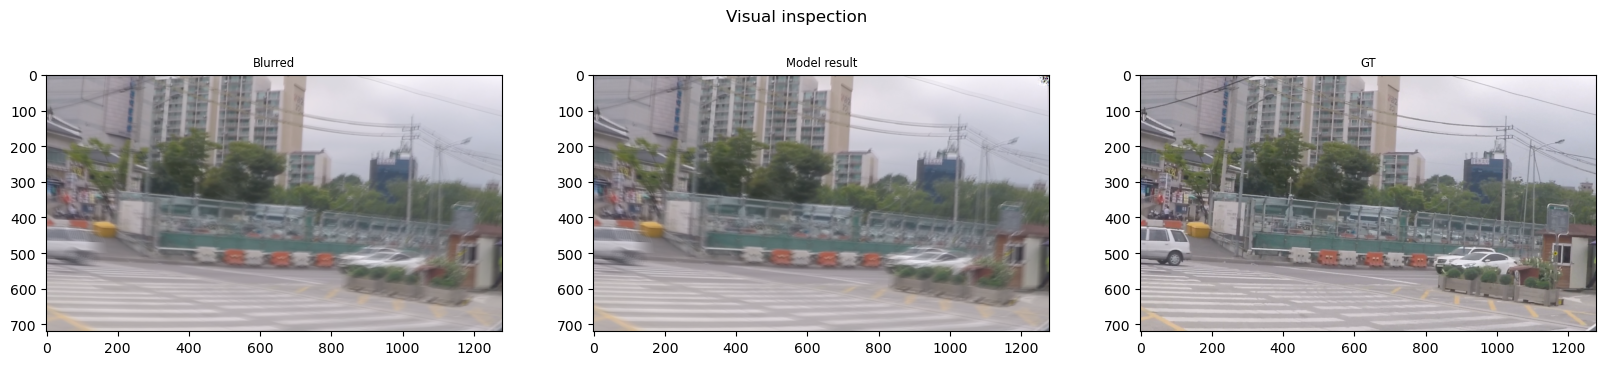

In [42]:
pics = test_dataset[2]
blurred, gt = pics[0], pics[1]
plt.figure(figsize=(20, 4))
plt.suptitle("Visual inspection")
plt.subplot(131)
plt.title("Blurred")
plt.imshow(blurred.permute(1, 2, 0))
plt.subplot(132)
plt.title("Model result")
with torch.no_grad():
    output = model(blurred.unsqueeze(0).to(device)).cpu().squeeze(0).permute(1, 2, 0).numpy()
output = np.clip(output, 0, 1)
plt.imshow(output)
plt.subplot(133)
plt.imshow(gt.permute(1, 2, 0))
plt.title("GT")
plt.show()

# Your thoughts

Please share your thoughts on the task.  
Did you like it, did you hate it?

If so, why?

Модельки обучаются, но наглядный результат не супер  
Мне кажется во первых модели недостаточно большие, плюс мы обучаем с 0 относительно мало эпох.  
Можно было бы попробовать использовать предобученные веса каких нибудь сверток, например resnet, 
а так же взять модель побольше и учить подольше, наверное результат был бы лучше.  